## Import Required Libraries

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Create DataFrame with Labels

In [6]:
import os
import pandas as pd

train_img_dir = "/dogs-vs-cats-redux-kernels-edition/train"
test_img_dir = "/dogs-vs-cats-redux-kernels-edition/test"

train_filenames = os.listdir(train_img_dir)
train_labels = [name.split(".")[0] for name in train_filenames]  # 'cat' or 'dog'

train_df = pd.DataFrame({"filename": train_filenames, "label": train_labels})
train_df["label"] = train_df["label"].astype(str)  # map to 0 and 1

## Train-Validation-Test Split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_temp = train_test_split(train_df, test_size=0.2, stratify=train_df["label"], random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, stratify=X_temp["label"], random_state=42)

## Load Data with ImageDataGenerator

In [8]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    X_train,
    directory=train_img_dir,
    x_col="filename",
    y_col="label",
    target_size=img_size,  
    class_mode="binary",
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    X_val,
    directory=train_img_dir,
    x_col="filename",
    y_col="label",
    target_size=img_size,  
    class_mode="binary",
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


## ResNet50 Base

In [9]:
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze all base layers initially
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

## Callbacks

In [10]:
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

## Train the Model

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


625/625 ━━━━━━━━━━━━━━━━━━━━ 662s 1s/step - accuracy: 0.9243 - loss: 0.1724 - val_accuracy: 0.9832 - val_loss: 0.0443 - learning_rate: 1.0000e-04
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 789s 1s/step - accuracy: 0.9792 - loss: 0.0542 - val_accuracy: 0.9828 - val_loss: 0.0496 - learning_rate: 1.0000e-04
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 744s 1s/step - accuracy: 0.9828 - loss: 0.0445 - val_accuracy: 0.9840 - val_loss: 0.0432 - learning_rate: 1.0000e-04
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 648s 1s/step - accuracy: 0.9840 - loss: 0.0411 - val_accuracy: 0.9840 - val_loss: 0.0455 - learning_rate: 1.0000e-04
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.9844 - loss: 0.0410 - val_accuracy: 0.9848 - val_loss: 0.0415 - learning_rate: 1.0000e-04
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.9853 - loss: 0.0382 - val_accuracy: 0.9828 - val_loss: 0.0430 - learning_rate: 1.0000e-04
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 624s 999ms/step - accuracy: 0

## Unfreeze top layers of ResNet50 for fine-tuning

In [12]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 876s 1s/step - accuracy: 0.9696 - loss: 0.0854 - val_accuracy: 0.9844 - val_loss: 0.0435 - learning_rate: 1.0000e-05
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 871s 1s/step - accuracy: 0.9823 - loss: 0.0483 - val_accuracy: 0.9836 - val_loss: 0.0439 - learning_rate: 1.0000e-05
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 890s 1s/step - accuracy: 0.9864 - loss: 0.0396 - val_accuracy: 0.9856 - val_loss: 0.0395 - learning_rate: 1.0000e-05
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 890s 1s/step - accuracy: 0.9903 - loss: 0.0296 - val_accuracy: 0.9888 - val_loss: 0.0371 - learning_rate: 1.0000e-05
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 910s 1s/step - accuracy: 0.9915 - loss: 0.0239 - val_accuracy: 0.9868 - val_loss: 0.0359 - learning_rate: 1.0000e-05


## Predict on Kaggle Test Folder

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_filenames = os.listdir(test_img_dir)
df_test = pd.DataFrame({"filename": test_filenames})

test_predict_gen = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_img_dir,
    x_col="filename",
    y_col=None,
    target_size=img_size,
    class_mode=None,
    shuffle=False,
    batch_size=1
)

preds = model.predict(test_predict_gen, verbose=1)

Found 12500 validated image filenames.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 480s 38ms/step


In [15]:
df_test = df_test[df_test["filename"].str.contains(r"\d+")]
df_test["id"] = df_test["filename"].str.extract(r"(\d+)")[0].astype(int)
df_test["label"] = preds.flatten()  # already in probability form

submission = df_test[["id", "label"]].sort_values("id")
submission.to_csv("submission.csv", index=False)

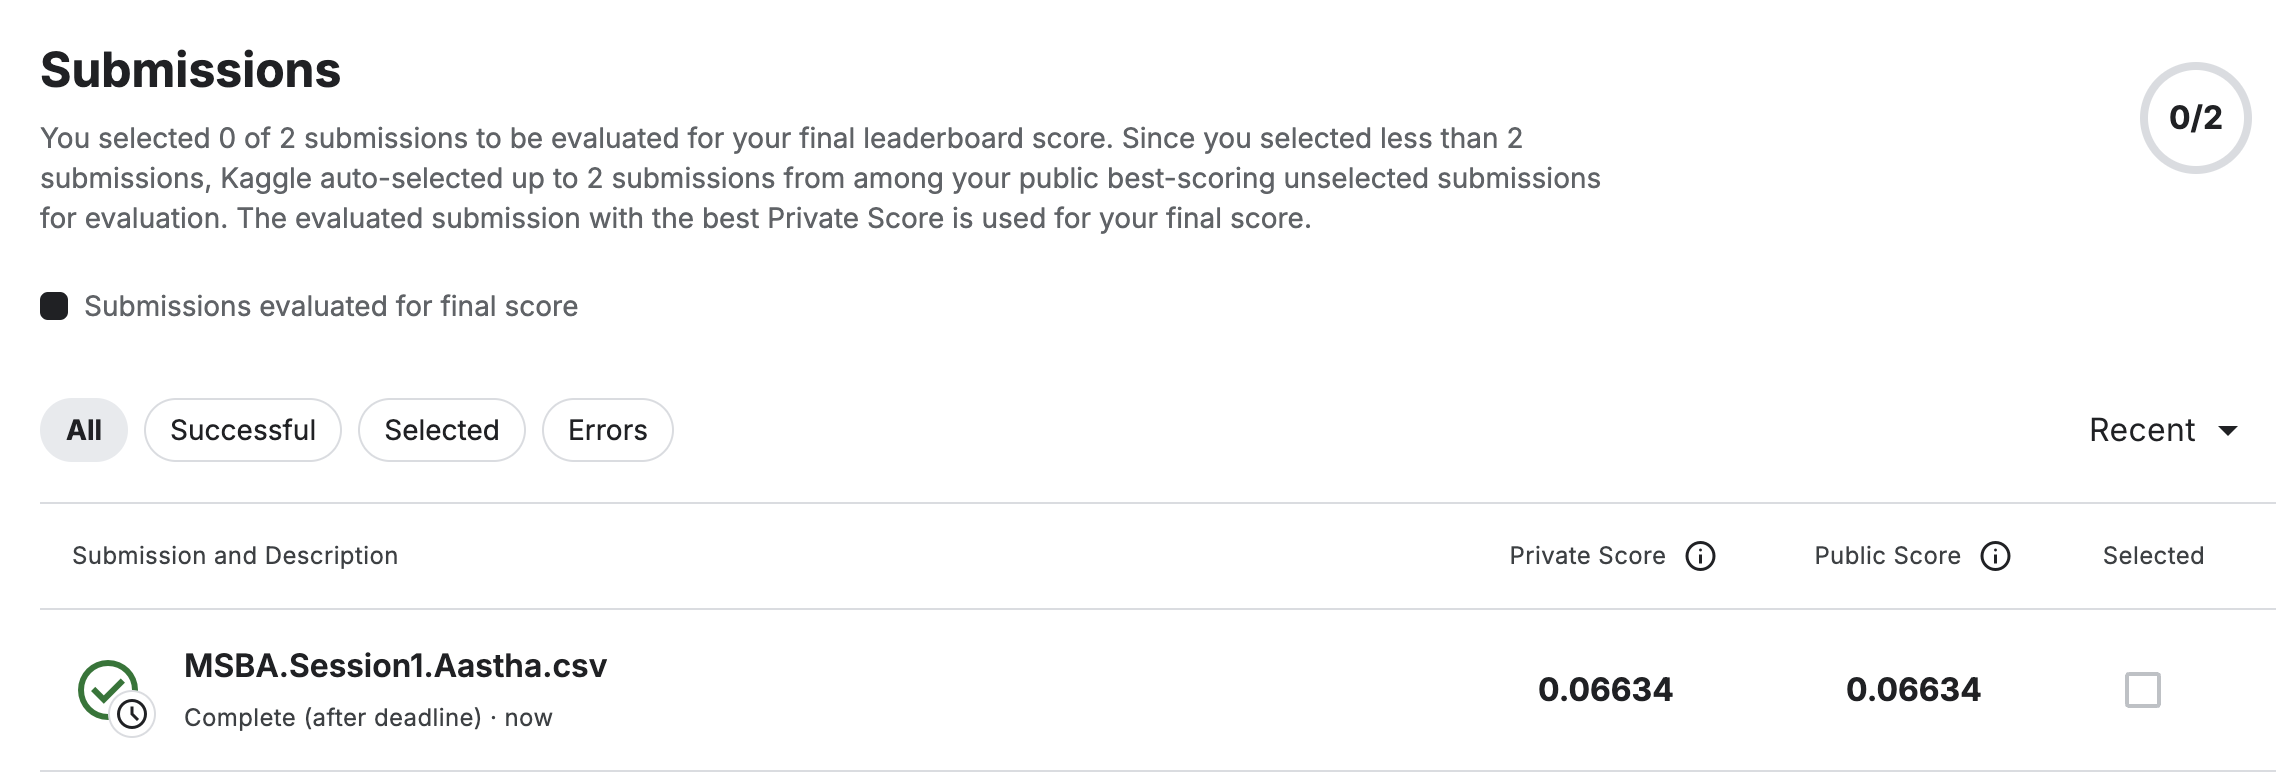